In [1]:
import pandas as pd
from decouple import config
import nilearn.plotting as plotting
import nilearn.image as img
from  nipype.interfaces import fsl
import glob
import os
import numpy as np
import re

In [2]:
def set_up_design_df(df: pd.DataFrame) -> pd.DataFrame:
    
    '''
    Function to set up dataframe for design matrix.
    DataFrame must be set up as :

    T1          |T2
    ----------- |-------------
    path_to_scan  path_to_scan

    Parameters
    ----------
    df: pd.DataFrame 
        Dataframe of participants scans

    Returns
    -------
    long_df: pd.Dataframe
            Dataframe in long form of group, time and intercept
    '''

    df['sub'] = df.index
    long_df = pd.melt(df, id_vars=['sub'], 
                      var_name='time_point', 
                      value_vars=['t1', 't2',], 
                      value_name='scans').sort_values(by=['sub'], ascending=True).reset_index(drop=True)
    long_df['group'] = long_df['scans'].apply(lambda participants: 0 if 'sub-G1' in participants or 'sub-B1' in participants else 1)
    long_df['time'] = long_df['time_point'].apply(lambda participants: 0 if 't1' in participants else 1)
    long_df['intercept'] = 1
    long_df = long_df.drop(long_df[long_df['sub'] == 75].index)

    return long_df

In [ ]:
def set_up_design_df(df: pd.DataFrame) -> pd.DataFrame:
    
    '''
    Function to set up dataframe for design matrix.
    DataFrame must be set up as :

    T1          |T2
    ----------- |-------------
    path_to_scan  path_to_scan

    Parameters
    ----------
    df: pd.DataFrame 
        Dataframe of participants scans

    Returns
    -------
    long_df: pd.Dataframe
            Dataframe in long form of group, time and intercept
    '''
    df['sub'] = df.index
    long_df = pd.melt(df, id_vars=['sub'], 
                    var_name='time_point', 
                    value_vars=['t1', 't2',], 
                    value_name='scans').sort_values(by=['sub'], ascending=True).reset_index(drop=True)
    long_df['group_hc'] = long_df['scans'].apply(lambda participants: 1 if 'sub-G1' in participants or 'sub-B1' in participants else 0)
    long_df['group_an'] = long_df['scans'].apply(lambda participants: 1 if 'sub-G2' in participants or 'sub-B2' in participants else 0)
    long_df['time_1'] = long_df['time_point'].apply(lambda participants: 0 if 't1' in participants else 1)
    long_df['time_2'] = long_df['time_point'].apply(lambda participants: 0 if 't2' in participants else 1)
    long_df['intercept'] = 1
    long_df = long_df.drop(long_df[long_df['sub'] == 75].index)

    return long_df

def create_design_matrix(path: str) -> dict:
    
    '''
    Function to create a design matrix

    Parameters
    ----------
    path: str
        File path to csv of participants scans
    out_directory: str
        Directory to store design matrix

    Returns
    ------
    dict : dictionary object
        Dictionary of list of scans and
        design matrix
        
    '''

    participant_scans = pd.read_csv(f"{path}/1stlevel_location.csv")
    long_df = set_up_design_df(participant_scans)
    scans = long_df['scans'].to_list()
    random_effects = pd.get_dummies(long_df['sub']).add_prefix('sub-')
    
    for column in random_effects:
        update = Contrast()
        random_effects[column] = random_effects[column].apply(update.contrast_genrator)
    
    design_matrix = pd.concat([long_df[['group_hc', 'group_an' , 'time_1', 'time_2']], 
                               random_effects], axis=1) 
    
    for column in design_matrix[['group', 'time', 'interaction']]:
            design_matrix[column] = design_matrix[column].apply(lambda val: 1 if val ==1 else -1)
    return  {
        'scans': scans,
        'design_matrix': design_matrix
    }

In [ ]:

    df['sub'] = df.index
    long_df = pd.melt(df, id_vars=['sub'], 
                      var_name='time_point', 
                      value_vars=['t1', 't2',], 
                      value_name='scans').sort_values(by=['sub'], ascending=True).reset_index(drop=True)
    long_df['group'] = long_df['scans'].apply(lambda participants: 0 if 'sub-G1' in participants or 'sub-B1' in participants else 1)
    long_df['time'] = long_df['time_point'].apply(lambda participants: 0 if 't1' in participants else 1)
    long_df['intercept'] = 1
    long_df = long_df.drop(long_df[long_df['sub'] == 75].index)

    return long_df

In [6]:
class Contrast:

    '''
    A simple class to change pd.Dummies into a 1 and -1.
    '''
    def __init__(self) -> None:
        self.counter = 0
    def contrast_genrator(self, val):
        if val == 1 and self.counter == 1:
            return -1
        else:
            self.counter += val
            return val

In [9]:
def create_design_matrix(path: str) -> dict:
    
    '''
    Function to create a design matrix

    Parameters
    ----------
    path: str
        File path to csv of participants scans
    out_directory: str
        Directory to store design matrix

    Returns
    ------
    dict : dictionary object
        Dictionary of list of scans and
        design matrix
        
    '''

    participant_scans = pd.read_csv(f"{path}/1stlevel_location.csv")
    long_df = set_up_design_df(participant_scans)
    scans = long_df['scans'].to_list()
    random_effects = pd.get_dummies(long_df['sub']).add_prefix('sub-')
    for column in random_effects:
        update = Contrast()
        random_effects[column] = random_effects[column].apply(update.contrast_genrator)
    interaction_effect = long_df['time'] * long_df['group']
    design_matrix = pd.concat([long_df[['group', 'time']], 
                               interaction_effect.rename('interaction'), 
                               random_effects], axis=1) 
    for column in design_matrix[['group', 'time', 'interaction']]:
            design_matrix[column] = design_matrix[column].apply(lambda val: 1 if val ==1 else -1)
    
    return  {
        'scans': scans,
        'design_matrix': design_matrix
    }

In [10]:
path = config('happy')
matrix_dict = create_design_matrix(path)
design_matrix = matrix_dict['design_matrix']
design_matrix

,group,time,interaction,sub-0,sub-1,sub-2,sub-3,sub-4,sub-5,sub-6,...,sub-83,sub-84,sub-85,sub-86,sub-87,sub-88,sub-89,sub-90,sub-91,sub-92
0,-1,-1,-1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,1,-1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,1,-1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,-1,-1,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1,-1,-1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,1,-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,0,0
182,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
183,1,-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,0
184,1,-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
hc = [-1 if re.search(r'G1|B1', participant) else -2 for participant in matrix_dict["scans"] ]

In [29]:
class Contrast:
    def __init__(self) -> None:
        self.counter = 0
    def contrast_genrator(self, val):
        if val == 1 and self.counter == 1:
            return -1
        else:
            self.counter += val
            return val

In [41]:
design_matrix.iloc[:,4:]

,sub-0,sub-1,sub-2,sub-3,sub-4,sub-5,sub-6,sub-7,sub-8,sub-9,...,sub-83,sub-84,sub-85,sub-86,sub-87,sub-88,sub-89,sub-90,sub-91,sub-92
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
for column in design_matrix.iloc[:,4:]:
    update = Contrast()
    design_matrix[column] = design_matrix[column].apply(update.contrast_genrator)

<AxesSubplot: label='conditions', ylabel='scan number'>

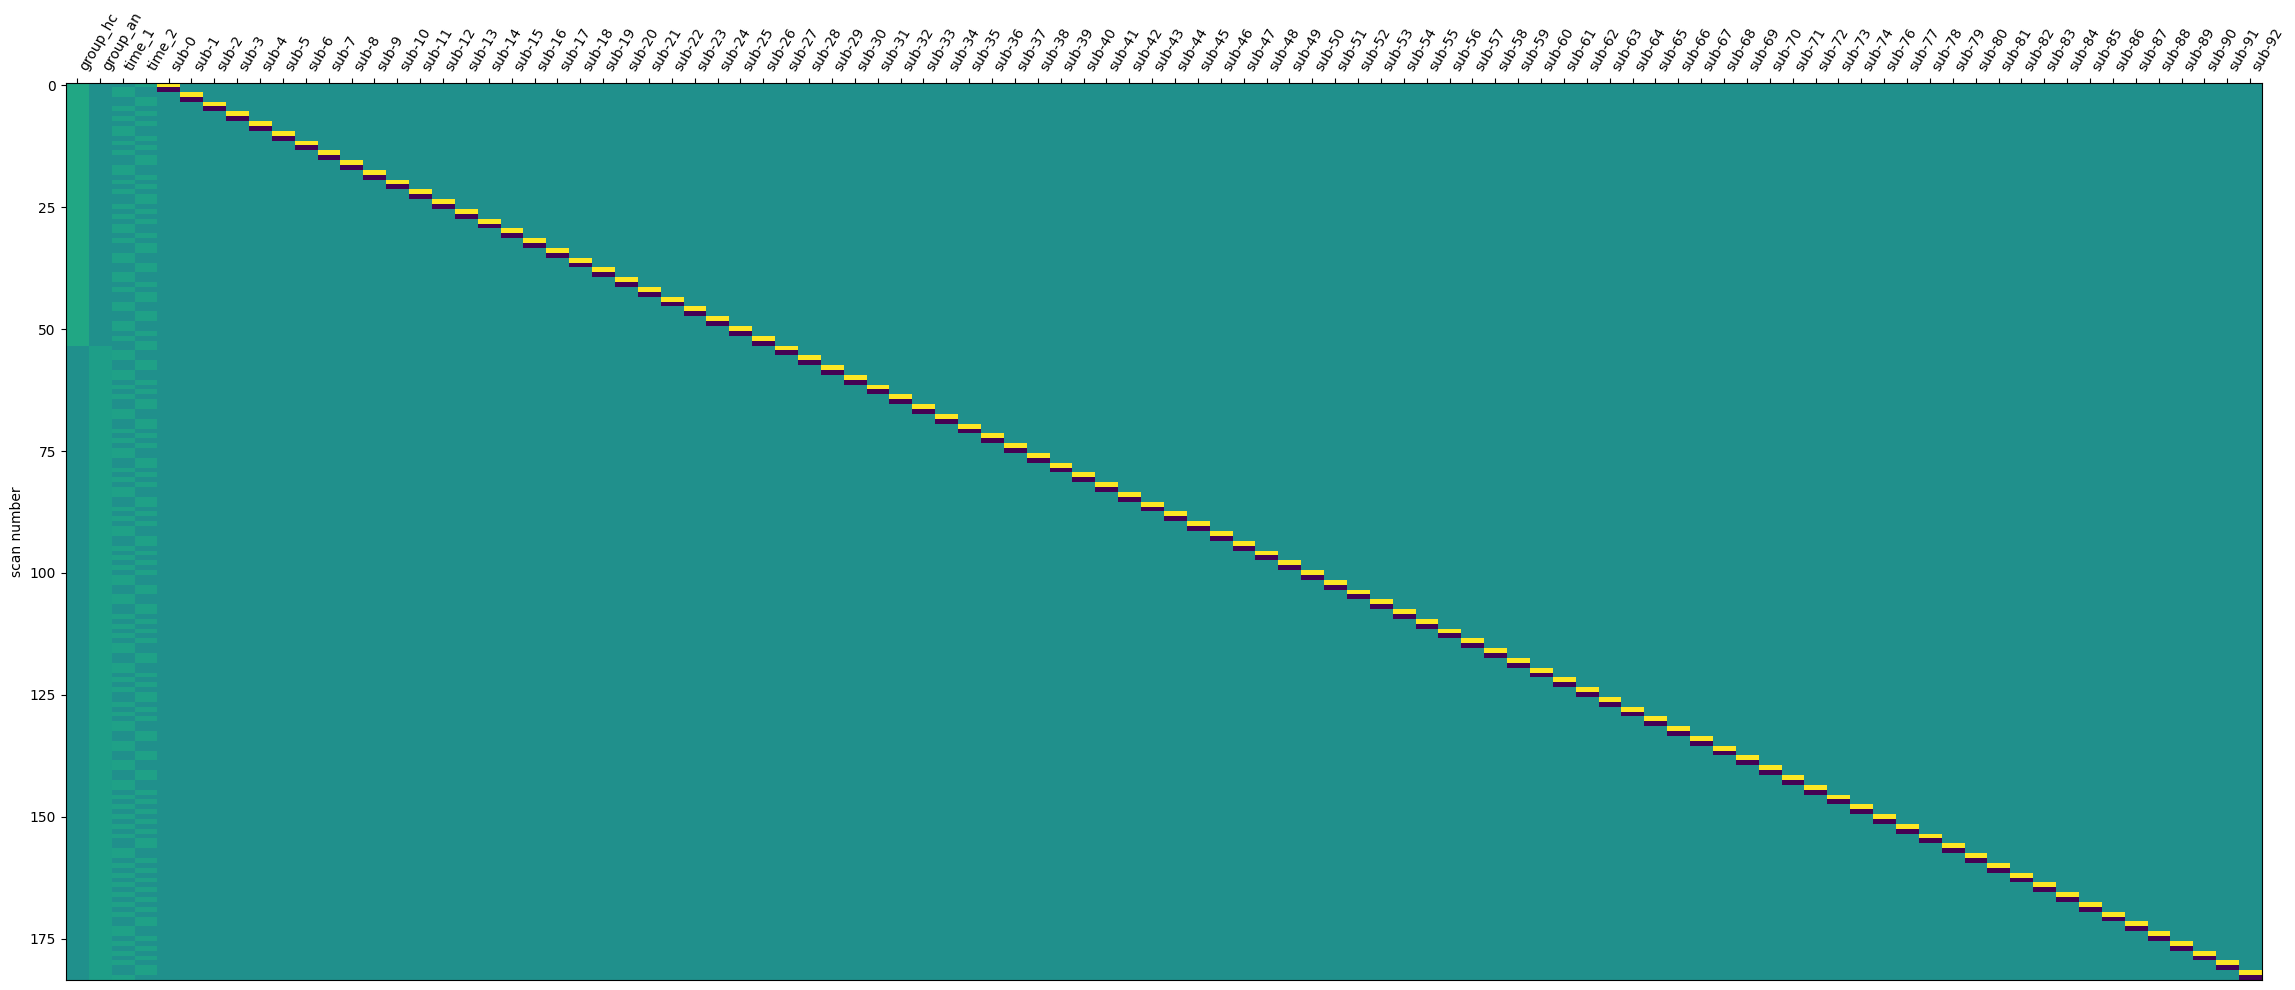

In [44]:
plotting.plot_design_matrix(design_matrix)

In [ ]:
within_subjects_design_matrix = 

In [5]:
time_test = [1 if re.search(r'G1|B1', participant) else 2 for participant in matrix_dict["scans"]]
group = [ if re.search(r'B1|B2', participant) else 2 for participant in matrix_dict["scans"]]

SyntaxError: invalid syntax (3699210565.py, line 2)

In [15]:
part = [re.findall(r'.\d\d\d\d' , participant.rstrip('con_0001.nii'))[0] for participant in matrix_dict["scans"]]

In [14]:
t_contrasts = np.vstack((
                        np.hstack(([-1, 1, 0, 0], np.zeros(design_matrix.shape[1] -2))), 
                        np.hstack(([0, 0, -1, 1], np.zeros(design_matrix.shape[1] -2))), 
                        np.hstack(([-1, 1, 1, -1], np.zeros(design_matrix.shape[1] -2)))
))

f_contrast = np.hstack(([1, 1, 1, 1], np.zeros(design_matrix.shape[1] -2)))
scans = matrix_dict['scans']
eb_data = {
        'block_one':   [1 for block in range(0, design_matrix.shape[0])],
        'group_block': sorted([block for block in range(1, design_matrix.shape[1] - 2)] + 
                              [block for block in range(1, design_matrix.shape[1] - 2)]),
        'time_block': [1 if re.search(r'G1|G2', participant) else 2 for participant in scans]
        }


In [ ]:
    t_contrasts = np.vstack((
        np.hstack(([1, -0.5, -0.5], np.zeros(design_matrix.shape[1] -3))), 
        np.hstack(([-0.5, 1, -0.5], np.zeros(design_matrix.shape[1] -3))), 
        np.hstack(([-0.5, -0.5, 1], np.zeros(design_matrix.shape[1] -3)))                  
    ))

    f_contrast = np.hstack(([1, 1, 1], np.zeros(design_matrix.shape[1] -3)))

In [7]:
eb_df = pd.DataFrame(eb_data)


In [16]:
    t_eb_data = {
        'block_one':   [1 for block in range(0, design_matrix.shape[0])],
        'group_block': sorted([block for block in range(1, design_matrix.shape[1] - 2)] + [block for block in range(1, design_matrix.shape[1] - 2)]),
        'time_block': [1 if re.search(r'G1|G2', participant) else 2 for participant in matrix_dict["scans"]]
        }
    
    t_eb_df = pd.DataFrame(t_eb_data)

ValueError: All arrays must be of the same length

In [7]:
def text_2_vest(in_file_name: str, out_file_name: str):
    t2v = fsl.Text2Vest()
    t2v.inputs.in_file = in_file_name
    t2v.inputs.out_file = out_file_name
    t2v.cmdline
    res = t2v.run() 

In [10]:
os.mkdir('.designfiles')
np.savetxt('.designfiles/design_mat.txt', design_matrix.values, fmt='%d')
np.savetxt('.designfiles/design_fts.txt', f_contrast, fmt='%d')
np.savetxt('.designfiles/design_grp.txt', exchange_blocks, fmt='%d')
np.savetxt('.designfiles/design_con.txt', t_contrasts, fmt='%d')


FileExistsError: [Errno 17] File exists: '.designfiles'

In [9]:
design = glob.glob('.designfiles/*.txt')

for design_file in design:
    out_file_name = re.sub(r'.txt|_', '.', design_file).rstrip('.')
    print(out_file_name)

.designfiles/design.con
.designfiles/design.fts
.designfiles/design.mat
.designfiles/design.grp


In [9]:
scans = matrix_dict['scans']

In [10]:
import re
brainmasks_path = [re.sub('con_0001.nii', 'func/*_task-happy_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz', scan) for scan in [re.sub('1stlevel/results/T', 'preprocessed_t', path) for path in  scans]]
brainmasks = [glob.glob(scan)[0] for scan in brainmasks_path]
brainmasks = [image for image in brainmasks if 'sub-B2' in image]
mean_mask = img.mean_img(brainmasks) 

In [12]:
mean_mask.to_filename('mask_img.nii.gz')

In [ ]:
group_mask = img.math_img("a>=0.95", a=mean_mask)
plotting.plot_roi(group_mask)

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


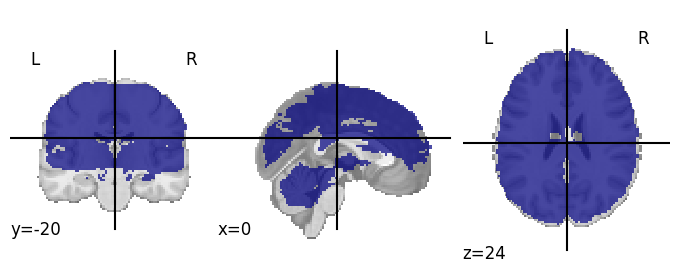

In [74]:
mean_mask = img.mean_img(scans) 
group_mask= img.binarize_img(mean_mask)
plotting.plot_roi(group_mask)

In [75]:
copes_concat = img.concat_imgs(scans, auto_resample=True)
happy_2ndlevel = os.path.join(path, '2ndlevel', 'fsl_test')
copes_concat.to_filename(os.path.join(happy_2ndlevel, 'linear_all_groups.nii.gz'))

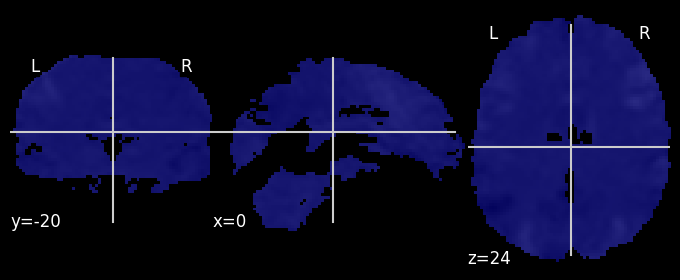

In [76]:
group_mask_sampled = img.resample_to_img(group_mask, copes_concat, interpolation='nearest')
group_mask_sampled.to_filename(os.path.join(happy_2ndlevel, "group_mask.nii.gz"))
plotting.plot_roi(group_mask_sampled, bg_img=img.mean_img(copes_concat))